In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import tqdm
from scipy.ndimage import gaussian_filter1d
import colorsys
import matplotlib.colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import gridspec
import matplotlib.patches

### Relabeling with Failures [Fig. 6]

  0%|          | 0/5 [00:00<?, ?it/s]

1 True
1

 20%|██        | 1/5 [00:10<00:43, 10.94s/it]

 False
3 True
3

 40%|████      | 2/5 [00:22<00:33, 11.11s/it]

 False
10 True
10

 60%|██████    | 3/5 [00:34<00:23, 11.54s/it]

 False
30 True
30

 80%|████████  | 4/5 [00:47<00:12, 12.39s/it]

 False
100 True
100

100%|██████████| 5/5 [01:07<00:00, 13.59s/it]

 False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

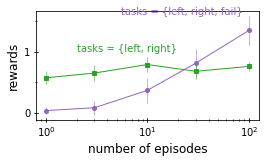

In [ ]:
height = 1
width = 11  # should be an odd number
num_s = height * width
start_i, start_j = (0, width // 2)
goals = [(0, 0),
         (0, width - 1)]
num_a = 3
gamma = 0.9

rc_params = {
             'xtick.direction': 'inout',
             'ytick.direction': 'inout',
             'font.family': 'sans-serif',
             'font.sans-serif': 'Roboto',
             'legend.frameon': False,
}
matplotlib.rcParams.update(rc_params)
c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']


def step(s, a):
  j = s
  if a == 0:
    j = max(0, j - 1)
  elif a == 1:
    j = j
  else:
    assert a == 2
    j = min(width - 1, j + 1)
  s = j
  return s

max_episode_steps = 7
def evaluate(pi):
  num_episodes = 100
  avg_time = []
  for goal_i, goal_j in goals:
    vec = []
    for _ in range(num_episodes):
      s = np.ravel_multi_index((start_i, start_j), (height, width))
      g = np.ravel_multi_index((goal_i, goal_j), (height, width))
      s_vec = []
      for t in range(max_episode_steps):
        s_vec.append(s)
        a = np.random.choice(num_a, p=pi[s, :, g])
        s = step(s, a)
      if goal_j == 0:
        vec.append(width // 2 - np.mean(s_vec))
      else:
        vec.append(np.mean(s_vec) - width // 2)
    avg_time.append(np.mean(vec))
  return avg_time


num_episodes_vec = [1, 3, 10, 30, 100]
results = {}
for num_episodes in tqdm.tqdm(num_episodes_vec):
  for use_fail in [True, False]:
    print(num_episodes, use_fail)
    result_vec = []
    for _ in range(100):
      pi_ocbc = np.ones((num_s, num_a, num_s)) / num_a
      counts = np.zeros((num_s, num_a, num_s)) + 0.01  # [s, a, ns]
      for _ in range(num_episodes):
        vec = []
        s = start_j
        i = np.random.choice(2)
        g = np.ravel_multi_index(goals[i], (height, width))
        for _ in range(max_episode_steps):
          a = np.random.choice(num_a, p=pi_ocbc[s, :, g])
          vec.append((s, a))
          s = step(s, a)
        vec = np.array(vec)
        for i in range(len(vec)):
          for j in range(i, min(i + 20, len(vec))):
            s1, a1 = vec[i]
            s2, a2 = vec[j]
            weight = gamma**(j - i)
            counts[s1, a1, s2] += weight

        if not use_fail:
          counts[:, :, :width // 2] = counts[:, :, :width//2].sum(-1)[:, :, None]
          counts[:, :, width // 2+1:] = counts[:, :, width//2+1:].sum(-1)[:, :, None]
        p_sag = counts / counts.sum()
        p_a_given_sg = p_sag / np.sum(p_sag, axis=1)[:, None, :]
        pi_ocbc = p_a_given_sg
      result_vec.append(np.mean(evaluate(pi_ocbc)))
    results[(num_episodes, use_fail)] = result_vec


custom_c_vec = [c_vec[2], c_vec[4]]
plt.figure(figsize=(4, 2))
for use_fail in [True, False]:
  y = [results[(num_episodes, use_fail)] for num_episodes in num_episodes_vec]
  y = np.array(y).reshape((len(num_episodes_vec), 10, 10)).mean(-1)
  mu = np.mean(y, axis=-1)
  std = np.std(y, axis=-1)
  a, b, c = plt.errorbar(num_episodes_vec, mu, yerr=std,
               marker='o' if use_fail else 's',
               elinewidth=0.5, c=custom_c_vec[int(use_fail)],
               linewidth=1, markersize=4)
  c[0].set_capstyle('round')
  plt.plot([np.nan], [np.nan],
            label='tasks = {left, right, fail}' if use_fail else 'tasks = {left, right}',
            marker='o' if use_fail else 's',
           c=custom_c_vec[int(use_fail)],
            linewidth=1, markersize=4)

plt.xlabel('number of episodes', fontsize=12)
plt.ylabel('rewards', fontsize=12)
plt.xscale('log')

plt.text(2, 1, 'tasks = {left, right}', c=custom_c_vec[0])
plt.text(5.5, 1.6, 'tasks = {left, right, fail}', c=custom_c_vec[1])

plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.5))

for axis in [plt.gca().xaxis, plt.gca().yaxis]:
  for i in axis.get_majorticklines():
    i._marker._capstyle = 'round'
  for i in axis.get_minorticklines():
    i._marker._capstyle = 'round'

filename = 'fig_6.pdf'
plt.savefig(filename, dpi=200, bbox_inches='tight')
plt.show()

### Bandit Problem [Fig. 3]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

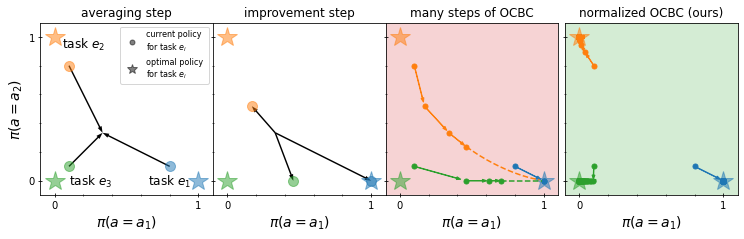

In [ ]:
### Show the improvement steps

rc_params = {
             'xtick.direction': 'inout',
             'ytick.direction': 'inout',
             'font.family': 'sans-serif',
             'font.sans-serif': 'Roboto',
             'legend.frameon': False,
}
matplotlib.rcParams.update(rc_params)

c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']
def p_to_xy(p):
  return xy
p_g_given_a = np.array([
  [0.33, 0, 0],
  [0.33, 1, 0.6],
  [0.34, 0, 0.4]])  # [num_goals, num_actions]
p_a_given_g = np.array([  # initial policy
  [0.8, 0.1, 0.1],
  [0.1, 0.8, 0.1],
  [0.1, 0.1, 0.8]])  # [num_goals, num_actions]
p_a_given_g_orig = p_a_given_g.copy()
p_g = np.ones(3) / 3

## compute the new policy
p_a = np.sum(p_a_given_g * p_g[:, None], axis=0)
p_ag = p_g_given_a * p_a[None]
p_g_new = p_ag.sum(axis=1)
p_a_given_g_old = p_a_given_g
p_a_given_g = p_ag / p_g_new[:, None]  # OCBC

### plotting
plt.figure(figsize=(12.5, 4))
outer_gs = gridspec.GridSpec(1, 2, width_ratios=(3, 1), wspace=0.02)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = outer_gs[0], hspace=0, wspace=0)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer_gs[1], hspace=0, wspace=0)


plt.subplot(gs1[0])
for g in range(3):
  p = p_a_given_g_old[g]
  plt.plot([p[0]], [p[1]], 'o', ms=10, c=c_vec[g], alpha=0.5)
  delta = p_a - p
  plt.arrow(p[0], p[1], delta[0], delta[1], length_includes_head=True,
            width=0.01, fc='k', linewidth=0)
  
  z = np.eye(3)[g]
  plt.plot([z[0]], [z[1]], marker='*', c=c_vec[g], markersize=20, alpha=0.5)

plt.plot([np.nan], [np.nan], 'o', ms=5, c='k', alpha=0.5,
          label='current policy \nfor task $e_i$')
plt.plot([np.nan], [np.nan], '*', ms=10, c='k', alpha=0.5,
          label='optimal policy \nfor task $e_i$')
plt.legend(loc='upper right', frameon=True, fontsize=8)

plt.gca().set_aspect('equal')
plt.xlabel('$\pi(a = a_1)$', fontsize=14)
plt.ylabel('$\pi(a = a_2)$', fontsize=14)
plt.title('averaging step')
plt.text(0.05, 0.95, 'task $e_2$', fontsize=12, va='center')
plt.text(0.65, 0, 'task $e_1$', fontsize=12, va='center')
plt.text(0.1, 0, 'task $e_3$', fontsize=12, va='center')
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.2))
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])


plt.subplot(gs1[1])
plt.gca().set_aspect('equal')
plt.xlabel('$\pi(a = a_1)$', fontsize=14)
for g in range(3):
  p = p_a_given_g[g]
  plt.plot([p[0]], [p[1]], 'o', ms=10, c=c_vec[g], alpha=0.5)  
  z = np.eye(3)[g]
  plt.plot([z[0]], [z[1]], marker='*', c=c_vec[g], markersize=20, alpha=0.5)
  delta = p - p_a
  plt.arrow(p_a[0], p_a[1], delta[0], delta[1], length_includes_head=True,
            width=0.01, fc='k', linewidth=0)

plt.title('improvement step')
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.2))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter(''))
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])



plt.subplot(gs1[2])
plt.title('many steps of OCBC')
plt.gca().set_aspect('equal')
plt.xlabel('$\pi(a = a_1)$', fontsize=14)


for g in range(3):
  z = np.eye(3)[g]
  plt.plot([z[0]], [z[1]], marker='*', c=c_vec[g], markersize=20, alpha=0.5)


policy_vec = []
p_a_given_g = p_a_given_g_orig.copy()
for _ in range(100):
  policy_vec.append(p_a_given_g.copy())
  p_a = np.sum(p_a_given_g * p_g[:, None], axis=0)
  p_ag = p_g_given_a * p_a[None]
  p_g_new = p_ag.sum(axis=1)
  p_a_given_g_old = p_a_given_g
  p_a_given_g = p_ag / p_g_new[:, None]  # OCBC

policy_vec = np.array(policy_vec)
cutoff = 3
for g in range(3):
  plt.plot(policy_vec[:cutoff+1, g, 0], policy_vec[:cutoff+1, g, 1], 'o', ms=5, c=c_vec[g])  
  plt.plot(policy_vec[cutoff:, g, 0], policy_vec[cutoff:, g, 1], '--', ms=5, c=c_vec[g])  

for i, (pi1, pi2) in enumerate(zip(policy_vec, policy_vec[1:])):
  delta = 0.9 * (pi2 - pi1)
  for g in range(3):
    if i < cutoff:
      plt.arrow(pi1[g, 0], pi1[g, 1], delta[g, 0], delta[g, 1], color=c_vec[g],
                width=0.003, length_includes_head=True, head_width=0.02)


plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.2))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter(''))
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.fill_between([-2, 2], -2, 2, color=c_vec[3], alpha=0.2)

plt.subplot(gs2[0])
plt.title('normalized OCBC (ours)')
plt.gca().set_aspect('equal')
plt.xlabel('$\pi(a = a_1)$', fontsize=14)

for g in range(3):
  z = np.eye(3)[g]
  plt.plot([z[0]], [z[1]], marker='*', c=c_vec[g], markersize=20, alpha=0.5)

policy_vec = []
p_a_given_g = p_a_given_g_orig.copy()
for _ in range(100):
  policy_vec.append(p_a_given_g.copy())
  p_a = np.sum(p_a_given_g * p_g[:, None], axis=0)
  p_ag = p_g_given_a * p_a[None]
  p_g_new = p_ag.sum(axis=1)
  p_a_given_g_old = p_a_given_g.copy()
  p_a_given_g = p_ag / p_g_new[:, None]  # OCBC
  p_a_given_g = p_a_given_g / p_a[None] * p_a_given_g_old
  p_a_given_g = p_a_given_g / np.sum(p_a_given_g, axis=1)[:, None]


policy_vec = np.array(policy_vec)
cutoff = 300
for g in range(3):
  plt.plot(policy_vec[:cutoff+1, g, 0], policy_vec[:cutoff+1, g, 1], 'o', ms=5, c=c_vec[g])  
  plt.plot(policy_vec[cutoff:, g, 0], policy_vec[cutoff:, g, 1], '--', ms=5, c=c_vec[g])  

for i, (pi1, pi2) in enumerate(zip(policy_vec, policy_vec[1:])):
  delta = 0.9 * (pi2 - pi1)
  for g in range(3):
    if i < cutoff:
      plt.arrow(pi1[g, 0], pi1[g, 1], delta[g, 0], delta[g, 1], color=c_vec[g],
                width=0.003, length_includes_head=True, head_width=0.02)


plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.2))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter(''))
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.fill_between([-2, 2], -2, 2, color=c_vec[2], alpha=0.2)

filename = 'fig_3.pdf'
plt.savefig(filename, dpi=200, bbox_inches='tight')
plt.show()

### Relating OCBC to reward maximization [Fig. 2]

Rewards of original policies: 3.50, 3.00
Rewards of new policies: 3.04, 2.61


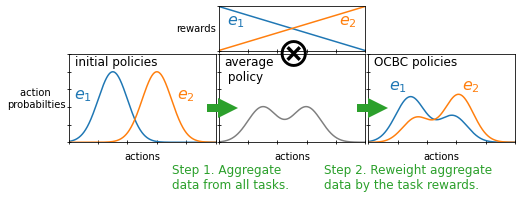

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rc_params = {
             'xtick.direction': 'inout',
             'ytick.direction': 'inout',
             'font.family': 'sans-serif',
             'font.sans-serif': 'Roboto',
             'legend.frameon': False,
}
matplotlib.rcParams.update(rc_params)

fig = plt.figure(figsize=(8, 2.5))

gs = gridspec.GridSpec(2, 3, hspace=0.05, wspace=0.02, height_ratios=(1, 2)) 

plt.subplot(gs[1, 0])
t = np.linspace(0, 5, 1000)
c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']
p1 = scipy.stats.norm(loc=1.5, scale=0.5).pdf(t)
p2 = scipy.stats.norm(loc=3, scale=0.5).pdf(t)
plt.plot(t, p1, c=c_vec[0])
plt.plot(t, p2, c=c_vec[1])
plt.text(0.5, 0.5, '$e_1$', fontsize=16, ha='center', c=c_vec[0])
plt.text(4, 0.5, '$e_2$', fontsize=16, ha='center', c=c_vec[1])
plt.ylim([0, 1])
plt.xlim([0, 5])
plt.xticks(range(6), [])
plt.yticks(np.linspace(0, 1, 6), [])
plt.xlabel('actions', fontsize=10)
plt.ylabel('action \nprobabilties', fontsize=10, rotation=0, labelpad=27, ha='center', va='center')
plt.text(0.2, 0.98, 'initial policies', fontsize=12, ha='left', va='top')
plt.title('Step 1. Aggregate \ndata from all tasks.', y=-0.3, ha='left', x=0.7,
          va='top', fontsize=12, c=c_vec[2])


plt.subplot(gs[0, 1])
r1 = 5 - t
r2 = t
plt.plot(t, r1, c=c_vec[0])
plt.plot(t, r2, c=c_vec[1])
plt.text(0.3, 3., '$e_1$', fontsize=16, ha='left', c=c_vec[0])
plt.text(4.7, 3., '$e_2$', fontsize=16, ha='right', c=c_vec[1])
plt.yticks(plt.yticks()[0], [])
plt.xlim(0, 5)
plt.ylim([0, 5])
plt.xticks(range(6), [])
plt.ylabel('rewards', rotation=0, fontsize=10, ha='center', va='center', labelpad=17)

plt.subplot(gs[1, 1])
p_avg = (p1 + p2) / 2.0
plt.plot(t, p_avg, c='k', alpha=0.5)
plt.xlabel('actions', fontsize=10)
plt.ylim([0, 1])
plt.yticks(np.linspace(0, 1, 6), [])
plt.text(0.2, 0.98, 'average\n policy', fontsize=12, ha='left', va='top')
plt.xlim([0, 5])
plt.xticks(range(6), [])
plt.text(2.5, 1, '$\\otimes$', fontsize=40, ha='center', va='center')


print('Rewards of original policies: %.2f, %.2f' % (
    p1 @ r1 / p1.sum(),
    p2 @ r2 / p2.sum(),
))
plt.subplot(gs[1, 2])
plt.title('Step 2. Reweight aggregate \ndata by the task rewards.', y=-0.3, ha='left', x=-0.3,
          va='top', fontsize=12, c=c_vec[2])
p1 = (p_avg * r1) * p1.sum() / np.sum(p_avg * r1)
plt.plot(t, p1, c=c_vec[0])

p2 = (p_avg * r2) * p2.sum() / np.sum(p_avg * r2)
plt.plot(t, p2, c=c_vec[1])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [])
plt.ylim([0, 1])
plt.text(0.2, 0.98, 'OCBC policies', fontsize=12, ha='left', va='top')
plt.text(1, 0.6, '$e_1$', fontsize=16, ha='center', c=c_vec[0])
plt.text(3.5, 0.6, '$e_2$', fontsize=16, ha='center', c=c_vec[1])
plt.xlim([0, 5])
plt.xticks(range(6), [])
plt.xlabel('actions', fontsize=10)

print('Rewards of new policies: %.2f, %.2f' % (
    p1 @ r1 / p1.sum(),
    p2 @ r2 / p2.sum(),
))


x = 205
y = 90
ar1 = matplotlib.patches.FancyArrowPatch(
    (x, y), (x + 35, y),
    fc = c_vec[2],
    arrowstyle='simple',
    mutation_scale = 40.,
    linewidth=0
)

x = 355
y = 90
ar2 = matplotlib.patches.FancyArrowPatch(
    (x, y), (x + 35, y),
    arrowstyle='simple',
    mutation_scale = 40.,
    fc=c_vec[2], linewidth=0,
)

fig.patches.append(ar1)
fig.patches.append(ar2)


filename = 'fig_2.pdf'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()



### 2D navigation [Fig. 4]

In [17]:
height = 2
width = 3
num_s = height * width
start_i, start_j = (1, 1)
goals = [(0, 0),
         (1, 2)]
num_a = 4
gamma = 0.9

rc_params = {
             'xtick.direction': 'inout',
             'ytick.direction': 'inout',
             'font.family': 'sans-serif',
             'font.sans-serif': 'Roboto',
             'legend.frameon': False,
}
matplotlib.rcParams.update(rc_params)
c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']

def step(s, a):
  if np.random.random() < 0.5:
    a = np.random.choice(4)
  i, j = np.unravel_index(s, (height, width))
  if a == 0:
    i = max(0, i - 1)
  elif a == 1:
    j = min(width - 1, j + 1)
  elif a == 2:
    i = min(height - 1, i + 1)
  else:
    j = max(0, j - 1)
  s = np.ravel_multi_index((i, j), (height, width))
  return s

num_episodes = 100
def evaluate(pi):
  max_episode_steps = 10
  avg_time = []
  for goal_i, goal_j in goals:
    vec = []
    for _ in range(num_episodes):
      s = np.ravel_multi_index((start_i, start_j), (height, width))
      g = np.ravel_multi_index((goal_i, goal_j), (height, width))
      for t in range(max_episode_steps):
        a = np.random.choice(num_a, p=pi[s, :, g])
        s = step(s, a)
        if s == g:
          break
      vec.append(t)
    avg_time.append(np.mean(vec))
  return avg_time


data = {}
for normalize in [True, False]:
  print(normalize)
  data[normalize] = []
  for _ in tqdm.trange(10):
    result_vec = []
    pi_ocbc = np.ones((num_s, num_a, num_s)) / num_a

    for iteration in range(20):
      result_vec.append(evaluate(pi_ocbc))
      counts = np.zeros((num_s, num_a, num_s)) + 0.01  # [s, a, ns]
      for _ in range(num_episodes):
        vec = []
        s = np.ravel_multi_index((start_i, start_j), (height, width))
        i = np.random.choice(2, p=[0.9, 0.1])  # p=[0.3, 0.3, 0.3, 0.1])
        g = np.ravel_multi_index(goals[i], (height, width))
        for _ in range(10):
          a = np.random.choice(num_a, p=pi_ocbc[s, :, g])
          vec.append((s, a))
          s = step(s, a)
        vec = np.array(vec)
        for i in range(len(vec)):
          for j in range(i, min(i + 20, len(vec))):
            s1, a1 = vec[i]
            s2, a2 = vec[j]
            weight = gamma**(j - i)
            counts[s1, a1, s2] += weight

      pi_ocbc_old = pi_ocbc.copy()
      p_sag = counts / counts.sum()
      p_a_given_sg = p_sag / np.sum(p_sag, axis=1)[:, None, :]
      
      if normalize:
        p_sa = p_sag.sum(axis=2)
        p_a_given_s = p_sa / p_sa.sum(axis=1)[:, None]
        Q = p_a_given_sg / p_a_given_s[:, :, None]
        pi_ocbc = Q * pi_ocbc_old
        pi_ocbc = pi_ocbc / pi_ocbc.sum(axis=1)[:, None, :]
      else:
        pi_ocbc = p_a_given_sg
    data[normalize] = data[normalize] + [result_vec]

True


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


False


100%|██████████| 10/10 [00:24<00:00,  2.40s/it]


In [ ]:
### Compute the performance of the optimal policy.
# We manually construct the optimal policy, and then evaluate it. This creates
# the horizontal lines in the following plot.

num_episodes = 10_000
def evaluate(pi):
  max_episode_steps = 10
  avg_time = []
  for goal_i, goal_j in goals:
    vec = []
    for _ in range(num_episodes):
      s = np.ravel_multi_index((start_i, start_j), (height, width))
      g = np.ravel_multi_index((goal_i, goal_j), (height, width))
      for t in range(max_episode_steps):
        a = np.random.choice(num_a, p=pi[s, :, g])
        s = step(s, a)
        if s == g:
          break
      vec.append(t)
    avg_time.append(np.mean(vec))
  return avg_time

pi = np.zeros((num_s, num_a, num_s))
for s in range(num_s):
  s_i, s_j = np.unravel_index(s, (height, width))
  for g in range(num_s):
    g_i, g_j = np.unravel_index(g, (height, width))
    if g_i < s_i:
      a = 0
    elif g_i > s_i:
      a = 2
    elif g_j < s_j:
      a = 3
    else:
      a = 1
    pi[s, a, g] = 1
evaluate(pi)

[2.7489, 1.2937]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

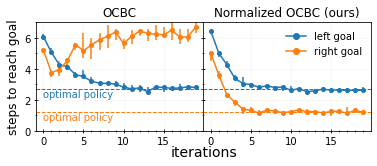

In [20]:
plt.figure(figsize=(6, 2))
for col, key in enumerate([False, True]):
  plt.subplot(1, 2, col + 1)
  result_vec_vec = np.array(data[key])
  for i in range(2):
    vec_vec = [result_vec[:, i] for result_vec in result_vec_vec]
    low, mid, high = np.quantile(vec_vec, [0.25, 0.5, 0.75], axis=0)
    plt.errorbar(np.arange(len(low)), mid, yerr=(mid - low, high - mid), c=c_vec[i],
                marker='o', markersize=4)
    plt.plot([np.nan], [np.nan], '-o', c=c_vec[i],
                 label='left goal' if i == 0 else 'right goal')
    y = 2.7 if i == 0 else 1.2
    plt.axhline(y, ls='--', linewidth=1, c=c_vec[i])
    if col == 0:
      plt.text(0, y, 'optimal policy', va='top', c=c_vec[i])
  if col == 0:
    plt.ylabel('steps to reach goal', fontsize=12)
    plt.title('OCBC')
  plt.gca().set_ylim([0, 7])
  plt.gca().yaxis.set_major_locator(MultipleLocator(2))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
  plt.gca().xaxis.set_major_locator(MultipleLocator(5))
  plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
  plt.grid(alpha=0.1)
  if col == 1:
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter(''))
    plt.title('Normalized OCBC (ours)')
    plt.text(-5, -1.6, 'iterations', fontsize=14)
    plt.legend(loc='upper right')

plt.subplots_adjust(wspace=0)
filename = 'fig_4.pdf'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
